# Spatial Pattern Analysis for 2009 311 pothole data & income analysis

Now I will import the usual libraries to be able to map out my data.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata

import seaborn as sns

from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

Now I want to import my actual data. I think the 2009 data should already be a geodataframe, so I have it saved like that in Jupyter so that I can use it later.

In [2]:
requests2009 = gpd.read_file('closed2009.geojson')

In [3]:
requests2009.head()

,REQUESTID,DATETIMEIN,SOURCE,DESCRIPTIO,REQCATEGOR,LAT,LONG,STATUS,DATETIMECL,COUNCILDIS,PROBADDRES,City,State,TIMETOCLOS,geometry
0,"312,392",8/11/2009 9:47,Phone or Email,Streets - Street Deterioration,STREETSW,37.769205,-122.204626,CLOSED,6/23/2016 19:04,CCD6,1521 54TH AV,Oakland,CA,2508.4,POINT (-122.20463 37.76920)
1,"310,597",7/20/2009 14:30,Phone or Email,Streets - Street Deterioration,STREETSW,37.760284,-122.202325,CLOSED,8/7/2015 9:53,CCD6,1100 62ND AVE,Oakland,CA,2208.8,POINT (-122.20232 37.76028)
2,"313,730",8/25/2009 11:40,Phone or Email,Streets/Sidewalks Maintenance - General,STREETSW,37.772975,-122.189995,CLOSED,7/21/2015 10:54,CCD6,5807 FLEMING AV,Oakland,CA,2156.0,POINT (-122.19000 37.77298)
3,"321,710",11/13/2009 14:59,Phone or Email,Streets - Street Deterioration,STREETSW,37.770417,-122.181830,CLOSED,7/21/2015 16:33,CCD6,FOOTHILL BLVD & HAVENSCOURT BLVD,Oakland,CA,2076.1,POINT (-122.18183 37.77042)
4,"320,858",11/5/2009 9:14,Phone or Email,Streets - Street Deterioration,STREETSW,37.737952,-122.171227,CLOSED,5/14/2014 17:14,CCD7,104TH AV & ROYAL ANN ST,Oakland,CA,1651.3,POINT (-122.17123 37.73795)


In [4]:
requests2009.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   REQUESTID   488 non-null    object  
 1   DATETIMEIN  488 non-null    object  
 2   SOURCE      488 non-null    object  
 3   DESCRIPTIO  488 non-null    object  
 4   REQCATEGOR  488 non-null    object  
 5   LAT         488 non-null    float64 
 6   LONG        488 non-null    float64 
 7   STATUS      488 non-null    object  
 8   DATETIMECL  488 non-null    object  
 9   COUNCILDIS  486 non-null    object  
 10  PROBADDRES  488 non-null    object  
 11  City        488 non-null    object  
 12  State       488 non-null    object  
 13  TIMETOCLOS  488 non-null    float64 
 14  geometry    488 non-null    geometry
dtypes: float64(3), geometry(1), object(11)
memory usage: 57.3+ KB


I just want to make sure that this data is the same as it was before, because I definitely have a lot of files in Jupyter now. I want to run quick data exploration with it all.

<AxesSubplot:>

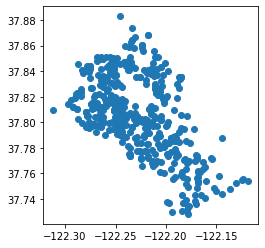

In [5]:
requests2009.plot()

In [6]:
requests2009.shape

(488, 15)

In [7]:
requests2009.TIMETOCLOS.value_counts()

14.0     6
4.0      6
4.3      5
5.8      5
14.9     4
        ..
152.2    1
152.7    1
152.9    1
153.0    1
84.1     1
Name: TIMETOCLOS, Length: 365, dtype: int64

Hmm, I have the time to close data in here as floats and not integers, so there will be less clear distributions of how long it takes for these requests to be closed. That's interesting that it consistently took something like 14 days for a lot of requests to be closed.

In [8]:
minx,miny,maxx,maxy = requests2009.total_bounds

In [9]:
requests2009.sort_values(by='TIMETOCLOS')

,REQUESTID,DATETIMEIN,SOURCE,DESCRIPTIO,REQCATEGOR,LAT,LONG,STATUS,DATETIMECL,COUNCILDIS,PROBADDRES,City,State,TIMETOCLOS,geometry
487,"323,244",12/6/2009 16:28,Phone or Email,Streets - Potholes/Depression,STREETSW,37.846023,-122.254899,CLOSED,12/6/2009 16:30,CCD1,5800 CLAREMONT AVE,Oakland,CA,0.0,POINT (-122.25490 37.84602)
486,"317,946",10/8/2009 15:58,Phone or Email,Streets - Potholes/Depression,STREETSW,37.832965,-122.264887,CLOSED,10/8/2009 16:00,CCD1,541 45TH STREET,Oakland,CA,0.0,POINT (-122.26489 37.83297)
485,"322,684",11/25/2009 11:17,Phone or Email,Streets/Sidewalks - Portable Barriers Maint,STREETSW,37.864062,-122.233286,CLOSED,11/25/2009 11:20,CCD1,CLAREMONT AV & RISPIN DR,Oakland,CA,0.0,POINT (-122.23329 37.86406)
484,"317,054",9/30/2009 13:50,Phone or Email,Streets - Potholes/Depression,STREETSW,37.779467,-122.205585,CLOSED,9/30/2009 15:09,CCD5,CONGRESS AV & COURTLAND AV,Oakland,CA,0.1,POINT (-122.20558 37.77947)
483,"317,437",10/5/2009 12:11,Phone or Email,Streets - Potholes/Depression,STREETSW,37.819132,-122.253446,CLOSED,10/5/2009 14:09,CCD2,OAKLAND AV & SANTA CLARA AV,Oakland,CA,0.1,POINT (-122.25345 37.81913)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,"320,858",11/5/2009 9:14,Phone or Email,Streets - Street Deterioration,STREETSW,37.737952,-122.171227,CLOSED,5/14/2014 17:14,CCD7,104TH AV & ROYAL ANN ST,Oakland,CA,1651.3,POINT (-122.17123 37.73795)
3,"321,710",11/13/2009 14:59,Phone or Email,Streets - Street Deterioration,STREETSW,37.770417,-122.181830,CLOSED,7/21/2015 16:33,CCD6,FOOTHILL BLVD & HAVENSCOURT BLVD,Oakland,CA,2076.1,POINT (-122.18183 37.77042)
2,"313,730",8/25/2009 11:40,Phone or Email,Streets/Sidewalks Maintenance - General,STREETSW,37.772975,-122.189995,CLOSED,7/21/2015 10:54,CCD6,5807 FLEMING AV,Oakland,CA,2156.0,POINT (-122.19000 37.77298)
1,"310,597",7/20/2009 14:30,Phone or Email,Streets - Street Deterioration,STREETSW,37.760284,-122.202325,CLOSED,8/7/2015 9:53,CCD6,1100 62ND AVE,Oakland,CA,2208.8,POINT (-122.20232 37.76028)


I'm trying to see if I can arrange this data to get a spatial analysis of the median time to close data.

In [10]:
requests2009 = requests2009.to_crs(epsg=3857)

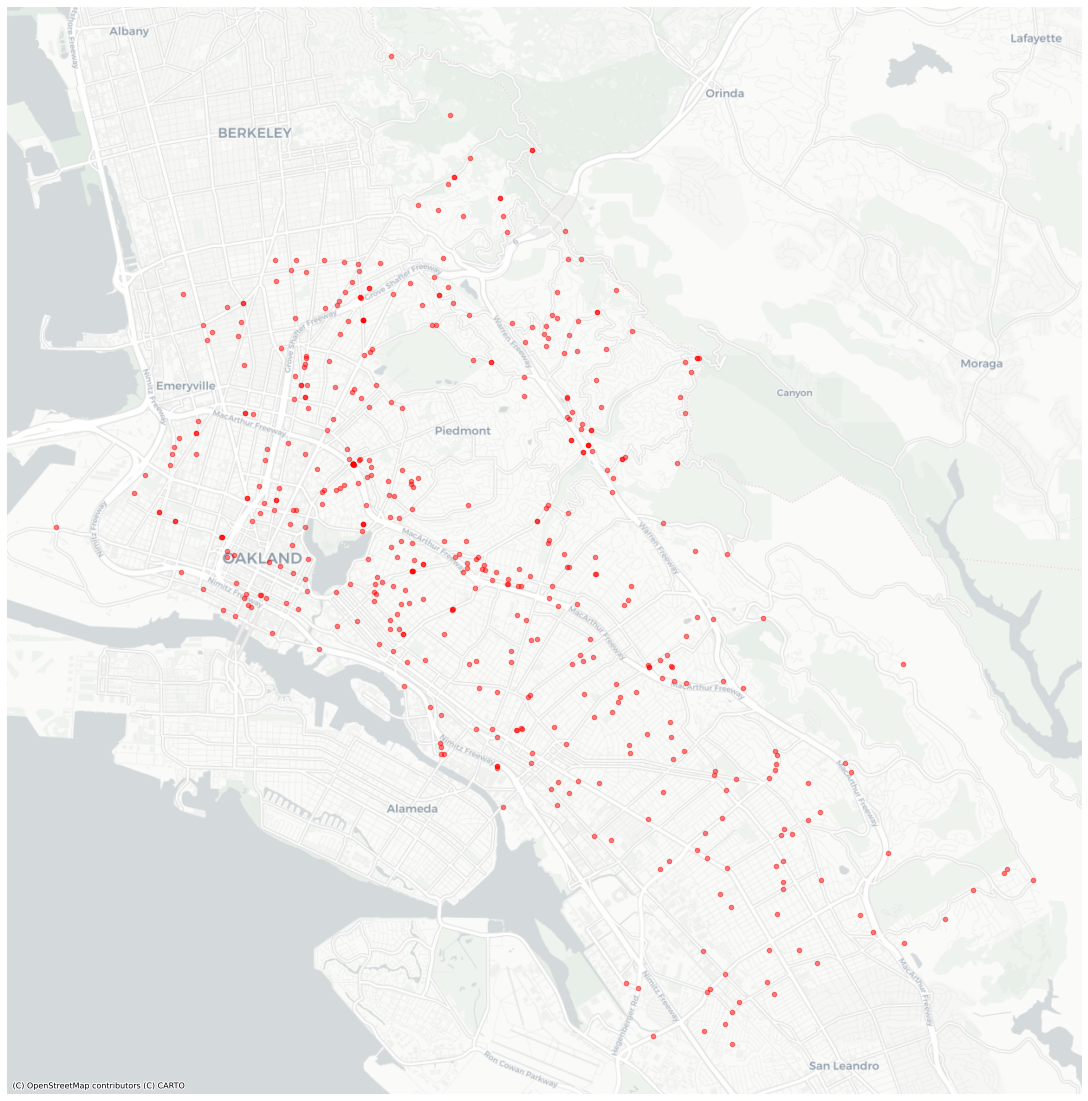

In [11]:
fig,ax = plt.subplots(figsize=(20,20))

requests2009.plot(ax=ax,
             color='red',
             markersize=20, alpha=0.5)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

for 2009, the data is so spread out that I don't think it helps to really look at the concentration of points so far. It will help more to organize them based on the time it took to close.

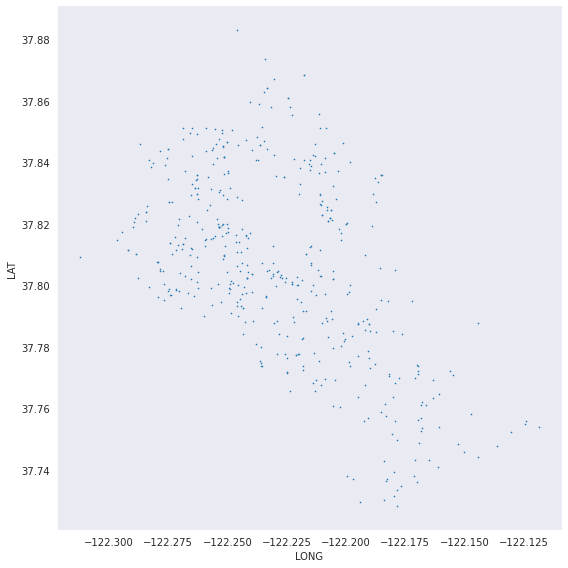

In [14]:
sns.set_style('dark')

sns.relplot(data=requests2009,
            x='LONG', 
            y='LAT',
            s=3,
            height=8)

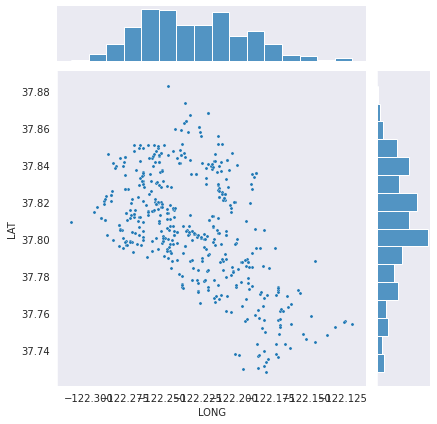

In [15]:
g = sns.jointplot(data = requests2009,
                  x='LONG', 
                  y='LAT',
                  s=10)

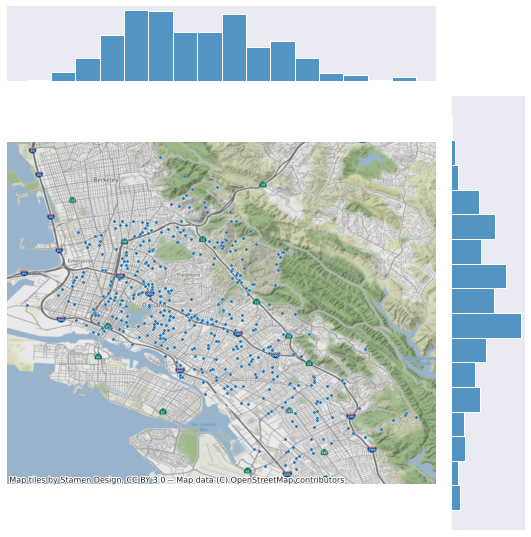

In [16]:
sns.set_style('dark')
g = sns.jointplot(data = requests2009,
                  x='LONG', 
                  y='LAT',
                  s=10,
                  height=8
                 )

g.ax_joint.set_axis_off()

ctx.add_basemap(g.ax_joint,
                crs='epsg:4326')

Okay, it's ugly but it's something!

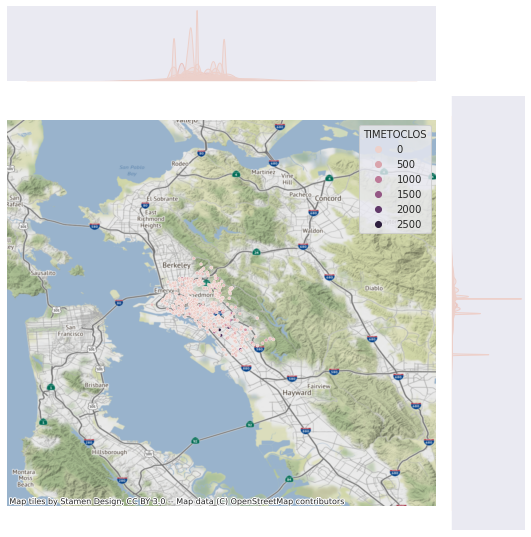

In [18]:
g = sns.jointplot(data = requests2009,
                  x='LONG', 
                  y='LAT',
                  hue='TIMETOCLOS',
                  s=10,
                  height=8
                 )

g.ax_joint.set_axis_off()

ctx.add_basemap(g.ax_joint,
                crs='epsg:4326')

I'm not sure if this is really the best way to approach this, especially as my time to close data is kind of limited for 2009. It will probably be better to do other measures of central tendency etc etc.

In [19]:
mean_center = centrography.mean_center(requests2009[['LONG','LAT']])
med_center = centrography.euclidean_median(requests2009[['LONG','LAT']])

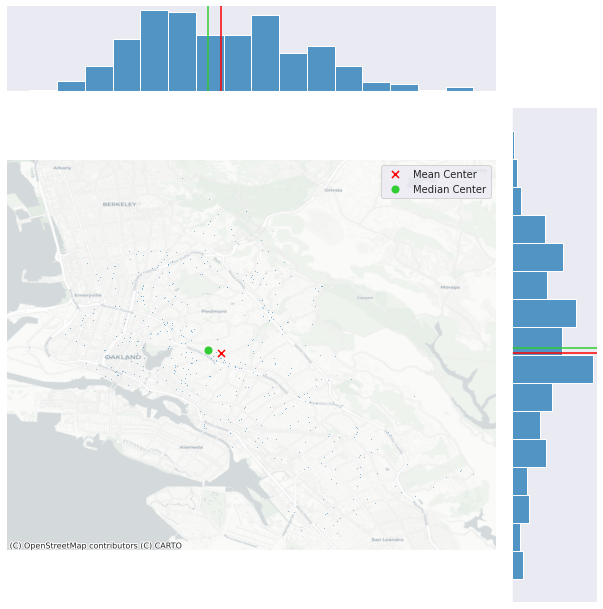

In [22]:
g = sns.jointplot(
    x='LONG', y='LAT', data=requests2009, s=0.75, height=9
)

g.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
g.ax_marg_x.axvline(mean_center[0], color='red')
g.ax_marg_y.axhline(mean_center[1], color='red')

g.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
g.ax_marg_x.axvline(med_center[0], color='limegreen')
g.ax_marg_y.axhline(med_center[1], color='limegreen')

g.ax_joint.legend()

ctx.add_basemap(
    g.ax_joint, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron
)

g.ax_joint.set_axis_off()

plt.show()

In [23]:
mean_center

array([-122.2286515 ,   37.80649667])

In [24]:
med_center

array([-122.23429088,   37.80804102])

In [25]:
major, minor, rotation = centrography.ellipse(requests2009[['LONG','LAT']])

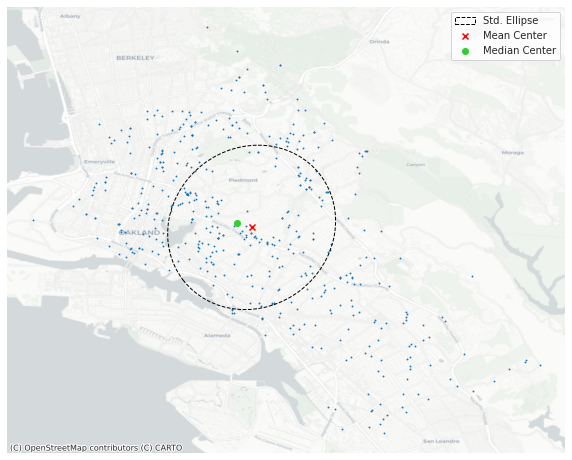

In [27]:
sns.set_style('white')

f, ax = plt.subplots(1, figsize=(10, 10))

ax.scatter(requests2009['LONG'], requests2009['LAT'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

ellipse = Ellipse(xy=mean_center,
                  width=major*2,
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation),
                  facecolor='none', 
                  edgecolor='black', 
                  linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

ax.axis('off')

ctx.add_basemap(ax,
                crs='epsg:4326',
                source=ctx.providers.CartoDB.Positron)

plt.show()

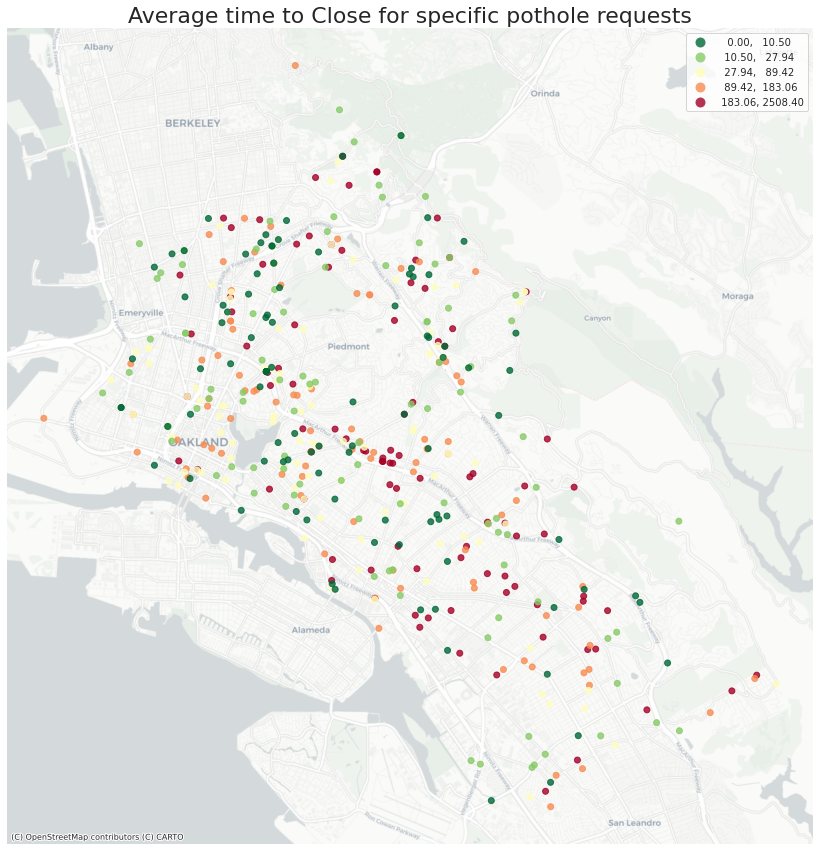

In [35]:
fig,ax = plt.subplots(figsize=(15,15))

requests2009.plot(ax=ax,
        column='TIMETOCLOS',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis('off')
ax.set_title('Average time to Close for specific pothole requests',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [38]:
import libpysal as lps

In [43]:
wq =  lps.weights.KNN.from_dataframe(requests2009,k=8)

ValueError: list.remove(x): x not in list

In [ ]:
I feel like I